In [6]:
# conda environment: "fepenv", python version=3.12.7

import pandas as pd
import sys
import biotite.database.rcsb as rcsb
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
import urllib.request
import pypdb
import os
import tqdm
import warnings
import pypdb
import redo
import matplotlib.pyplot as plt
import numpy as np


from IPython.display import display, HTML
import ipywidgets as widgets

# Querying PDB based on methodological/protein requirements using biotite

In [3]:
# https://search.rcsb.org/structure-search-attributes.html

# Methodology
experimental_method = "X-ray"
resolution_combined = 3.5
deposition_date = "2010-01-01T00:00:00Z"

# Protein characteristics
membrane_annotations = ['PDBTM', 'MemProtMD'] # 'PDBTM', 'OPM', 'MemProtMD', 'mpstruc'
organism = "Homo sapiens"

# Ligand characteristics
min_ligand_molecular_weight = 100
ligand_binding_type = "HAS_NO_COVALENT_LINKAGE"
ligand_binding_class = "Antagonist" # doesn't seem to be annotated in (nearly) any structure mmCIFs

In [4]:
query_by_experimental_method = rcsb.FieldQuery(
    "rcsb_entry_info.experimental_method",
    exact_match=experimental_method
)

query_by_resolution = rcsb.FieldQuery(
    "rcsb_entry_info.resolution_combined",
    less_or_equal=resolution_combined
)

query_by_deposition_date = rcsb.FieldQuery(
    "rcsb_accession_info.deposit_date", 
    greater=deposition_date
)

query_by_ligand_mw = rcsb.FieldQuery(
    "chem_comp.formula_weight",
    molecular_definition=True,
    greater=min_ligand_molecular_weight
)

query_by_membrane_annotation = rcsb.FieldQuery(
    "rcsb_polymer_entity_annotation.type",
    is_in=membrane_annotations
)

query_by_organism = rcsb.FieldQuery(
    "rcsb_entity_source_organism.scientific_name",
    exact_match=organism
)

query_by_ligand_binding_type = rcsb.FieldQuery(
    "rcsb_nonpolymer_instance_annotation.type",
    exact_match=ligand_binding_type
)

# query_by_ligand_class = rcsb.FieldQuery(
#     "pdbx_molecule_features.class",
#     exact_match=ligand_binding_class
# )

In [5]:
query = rcsb.CompositeQuery(
    [
        query_by_resolution,
        query_by_experimental_method,
        query_by_membrane_annotation,
        query_by_organism,
        query_by_ligand_mw,
        query_by_ligand_binding_type,
        query_by_deposition_date, 
    ],
    "and",
)

pdb_ids = rcsb.search(query)
print(f"{len(pdb_ids)} matches:")
print(pdb_ids)

# 2.0 Ä -> ~50-60 matches
# 2.5 Ä -> ~180 matches
# 3.0 Ä -> ~400 matches
# 3.5 Ä -> ~570 matches

569 matches:
['2XCG', '2XFN', '2XFO', '2XFP', '2XFQ', '2YDO', '2YDV', '3B29', '3LEO', '3NY8', '3NY9', '3NYA', '3ODU', '3OE6', '3OE8', '3OE9', '3P0G', '3PBL', '3PCV', '3PDS', '3PO7', '3PWH', '3REY', '3RZE', '3SN6', '3UKM', '3UM7', '3UON', '3UZA', '3UZC', '3V2W', '3V2Y', '3V8X', '3VG9', '3VGA', '3VW7', '3ZDQ', '3ZYX', '4A79', '4A7A', '4AL0', '4AL1', '4AW6', '4AYT', '4AYW', '4AYX', '4BPM', '4BW5', '4COF', '4DCB', '4DJH', '4EA3', '4EIY', '4G7V', '4G7Y', '4I9W', '4IAQ', '4IAR', '4IB4', '4J7T', '4J7Y', '4JC7', '4JCZ', '4JKV', '4JRZ', '4K5Y', '4KFM', '4L6R', '4LDE', '4LDL', '4LDO', '4MBS', '4MQS', '4N4W', '4N6H', '4NC3', '4NEF', '4NTJ', '4O9R', '4OO9', '4OR2', '4PHU', '4PXZ', '4PY0', '4PYP', '4QIM', '4QIN', '4QKX', '4RUE', '4RUF', '4RWA', '4RWD', '4S0V', '4TWK', '4UG2', '4UHR', '4WAB', '4WFE', '4WFF', '4WFG', '4WFH', '4WO1', '4WOL', '4X5T', '4XDL', '4XNV', '4XNW', '4XT1', '4YAY', '4YK5', '4YL0', '4YL1', '4YL3', '4Z34', '4Z35', '4Z36', '4Z9G', '4ZJ8', '4ZJC', '4ZUD', '4ZW9', '4ZWC', '4ZYO', '5

# Downloading `.pdb` and `.cif` file for selected PDB entries with pypdb

In [ ]:
# def download_pdb_cif_from_pdbid(pdb_id):
#     folder_name = "proteins"
#     file_path = os.path.join(folder_name, pdb_id)
#     os.makedirs(folder_name, exist_ok=True)

#     warnings.simplefilter("ignore") # ignore deprecation warning
#     cifstring = pypdb.get_pdb_file(pdb_id, filetype='cif', compression=False)
#     with open((file_path+".cif"), "w") as file:
#         file.write(cifstring)

#     warnings.simplefilter("ignore") # ignore deprecationwarning
#     pdbstring = pypdb.get_pdb_file(pdb_id, filetype="pdb", compression=False)
#     with open((file_path+".pdb"), "w") as file:
#         file.write(pdbstring)


# def download_pdb_cif_from_pdbid(pdb_id):
#     folder_name = "proteins"
#     file_path = os.path.join(folder_name, pdb_id)
#     os.makedirs(folder_name, exist_ok=True)

#     print(f"Downloading and saving to {file_path}")

#     try:
#         # Fetch and save CIF file
#         warnings.simplefilter("ignore")  # Ignore deprecation warnings
#         cifstring = pypdb.get_pdb_file(pdb_id, filetype='cif', compression=False)
#         if cifstring:
#             with open((file_path + ".cif"), "w") as file:
#                 file.write(cifstring)
#         else:
#             print(f"CIF file is None for PDB ID {pdb_id}, skipping.")

#         # Fetch and save PDB file
#         pdbstring = pypdb.get_pdb_file(pdb_id, filetype="pdb", compression=False)
#         if pdbstring:
#             with open((file_path + ".pdb"), "w") as file:
#                 file.write(pdbstring)
#         else:
#             print(f"PDB file is None for PDB ID {pdb_id}, skipping.")

#     except TypeError as e:
#         print(f"TypeError for PDB ID {pdb_id}: {e}. Skipping.")
#     except Exception as e:
#         print(f"An unexpected error occurred for PDB ID {pdb_id}: {e}. Skipping.")

In [7]:
def download_pdb_cif_from_pdbid(pdb_id):
    folder_name = "proteins"
    file_path = os.path.join(folder_name, pdb_id)
    os.makedirs(folder_name, exist_ok=True)

    cif_file_path = file_path + ".cif"
    pdb_file_path = file_path + ".pdb"

    # Check if files already exist
    if os.path.exists(cif_file_path):
        print(f"CIF file for PDB ID {pdb_id} already exists, skipping download.")
    if os.path.exists(pdb_file_path):
        print(f"PDB file for PDB ID {pdb_id} already exists, skipping download.")

    # Download only if necessary
    try:
        # Fetch and save CIF file if not already downloaded
        if not os.path.exists(cif_file_path):
            warnings.simplefilter("ignore")  # Ignore deprecation warnings
            cifstring = pypdb.get_pdb_file(pdb_id, filetype='cif', compression=False)
            if cifstring:
                with open(cif_file_path, "w") as file:
                    file.write(cifstring)
                print(f"CIF file downloaded and saved to {cif_file_path}")
            else:
                print(f"CIF file is None for PDB ID {pdb_id}, skipping.")

        # Fetch and save PDB file if not already downloaded
        if not os.path.exists(pdb_file_path):
            pdbstring = pypdb.get_pdb_file(pdb_id, filetype="pdb", compression=False)
            if pdbstring:
                with open(pdb_file_path, "w") as file:
                    file.write(pdbstring)
                print(f"PDB file downloaded and saved to {pdb_file_path}")
            else:
                print(f"PDB file is None for PDB ID {pdb_id}, skipping.")

    except TypeError as e:
        print(f"TypeError for PDB ID {pdb_id}: {e}. Skipping.")
    except Exception as e:
        print(f"An unexpected error occurred for PDB ID {pdb_id}: {e}. Skipping.")

In [8]:
for pdb_id in tqdm.tqdm(pdb_ids):
    download_pdb_cif_from_pdbid(pdb_id);

  0%|          | 0/569 [00:00<?, ?it/s]/opt/anaconda3/envs/fepenv/lib/python3.12/site-packages/pypdb/pypdb.py:497: DeprecationWarning: The `get_pdb_file` function within pypdb.py is deprecated.See `pypdb/clients/pdb/pdb_client.py` for a near-identical function to use
  warnings.warn(


CIF file for PDB ID 2XCG already exists, skipping download.
PDB file for PDB ID 2XCG already exists, skipping download.
CIF file for PDB ID 2XFN already exists, skipping download.
PDB file for PDB ID 2XFN already exists, skipping download.
CIF file for PDB ID 2XFO already exists, skipping download.
PDB file for PDB ID 2XFO already exists, skipping download.
CIF file for PDB ID 2XFP already exists, skipping download.
PDB file for PDB ID 2XFP already exists, skipping download.
CIF file for PDB ID 2XFQ already exists, skipping download.
PDB file for PDB ID 2XFQ already exists, skipping download.
CIF file for PDB ID 2YDO already exists, skipping download.
PDB file for PDB ID 2YDO already exists, skipping download.
CIF file for PDB ID 2YDV already exists, skipping download.
PDB file for PDB ID 2YDV already exists, skipping download.
CIF file for PDB ID 3B29 already exists, skipping download.
PDB file for PDB ID 3B29 already exists, skipping download.
CIF file for PDB ID 3LEO already exists,

/opt/anaconda3/envs/fepenv/lib/python3.12/site-packages/pypdb/util/http_requests.py:65: UserWarning: Too many failures on requests. Exiting...
  warnings.warn("Too many failures on requests. Exiting...")
/opt/anaconda3/envs/fepenv/lib/python3.12/site-packages/pypdb/clients/pdb/pdb_client.py:83: UserWarning: Retrieval failed, returning None
  warnings.warn("Retrieval failed, returning None")
100%|██████████| 569/569 [00:01<00:00, 365.60it/s]

PDB file is None for PDB ID 4DCB, skipping.
CIF file for PDB ID 4DJH already exists, skipping download.
PDB file for PDB ID 4DJH already exists, skipping download.
CIF file for PDB ID 4EA3 already exists, skipping download.
PDB file for PDB ID 4EA3 already exists, skipping download.
CIF file for PDB ID 4EIY already exists, skipping download.
PDB file for PDB ID 4EIY already exists, skipping download.
CIF file for PDB ID 4G7V already exists, skipping download.
PDB file for PDB ID 4G7V already exists, skipping download.
CIF file for PDB ID 4G7Y already exists, skipping download.
PDB file for PDB ID 4G7Y already exists, skipping download.
CIF file for PDB ID 4I9W already exists, skipping download.
PDB file for PDB ID 4I9W already exists, skipping download.
CIF file for PDB ID 4IAQ already exists, skipping download.
PDB file for PDB ID 4IAQ already exists, skipping download.
CIF file for PDB ID 4IAR already exists, skipping download.
PDB file for PDB ID 4IAR already exists, skipping downlo

In [9]:
# from https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T008_query_pdb/talktorial.ipynb
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    """Fetch meta information from PDB."""
    described = pypdb.describe_pdb(pdb_id)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying ...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

In [10]:
pdbs_data = [describe_one_pdb_id(pdb_id) for pdb_id in tqdm.tqdm(pdb_ids)]

100%|██████████| 569/569 [03:12<00:00,  2.96it/s]


# Quality assessment of X-ray crystallography structures
Based on the guidelines of [Hahn et al. 2022](https://doi.org/10.33011/livecoms.4.1.1497).

**Overfit structure**
To identify an *overfit structure*, the difference of [R and Rfree residual factors](https://en.wikipedia.org/wiki/R-factor_(crystallography)) exceeds 0.05. (p.8 Hahn 2022)

**Coordinate error**
High quality structures should have a coordinate error (ESU R_free) < 0.07 (p.8 Hahn 2022), this is the same advisory boundary as defined in the [mmCIF dictionary](https://mmcif.wwpdb.org/dictionaries/mmcif_pdbx_v50.dic/Items/_refine.pdbx_overall_ESU_R_Free.html).

In [12]:
structures = pd.DataFrame(
    [
        [
            pdb_data.get("entry", {}).get("id", None),
            pdb_data.get("rcsb_entry_info", {}).get("resolution_combined", [None])[0],
            pdb_data.get("refine", [{}])[0].get("ls_rfactor_obs", None),
            pdb_data.get("refine", [{}])[0].get("ls_rfactor_rfree", None),
            pdb_data.get("refine", [{}])[0].get("pdbx_overall_esurfree", None)

        ]
        for pdb_data in pdbs_data
    ],
    columns=["pdb_id", "resolution", "R-factor", "R-free-factor", "Coordinate_Error_(ESU_Rfree)"]
).sort_values(by="resolution")

# Hahn et al. 2022, p. 8 (https://doi.org/10.33011/livecoms.4.1.1497)
structures['R/Rfree_overfit'] = np.abs(structures['R-factor'] - structures['R-free-factor']) > 0.05

structures

,pdb_id,resolution,R-factor,R-free-factor,Coordinate_Error_(ESU_Rfree),R/Rfree_overfit
40,4AL0,1.16,0.12231,0.12964,0.020,False
217,5TL9,1.20,0.15280,0.16801,0.028,False
162,5K0I,1.30,0.14619,0.15917,0.032,False
211,5T36,1.40,0.18415,0.19483,0.048,False
437,6VL4,1.40,0.13980,0.14500,0.007,False
...,...,...,...,...,...,...
103,4X5T,3.50,0.25430,0.27000,NaN,False
104,4XDL,3.50,0.23660,0.26330,NaN,False
72,4MQS,3.50,0.25440,0.29820,NaN,False
138,5DYE,3.50,0.28036,0.31096,0.661,False


In [13]:
structures.to_csv('structures.csv', index=False)

In [14]:
print(f"Number of entries: {structures.shape[0]}")
print(f"Number of entries with R/Rfree overfit (difference <= 0.05): {structures[structures['R/Rfree_overfit'] == 'True'].shape[0]}")
print(f"Number of entries with missing values: {structures.isnull().sum().sum()}")
print(f"Number of entries with coordinate error >= 0.7: {structures[structures['Coordinate_Error_(ESU_Rfree)'] >= 0.7].shape[0]} \n")

structuresfiltered = structures.dropna()
structuresfiltered = structuresfiltered[structuresfiltered['R/Rfree_overfit'] != 'True']
structuresfiltered = structuresfiltered[structuresfiltered['Coordinate_Error_(ESU_Rfree)'] < 0.7]

print(f"Number of entries in filtered set: {structuresfiltered.shape[0]}")

Number of entries: 569
Number of entries with R/Rfree overfit (difference <= 0.05): 0
Number of entries with missing values: 454
Number of entries with coordinate error >= 0.7: 0 

Number of entries in filtered set: 124


In [15]:
structuresfiltered.to_csv('structures_filtered.csv', index=False)

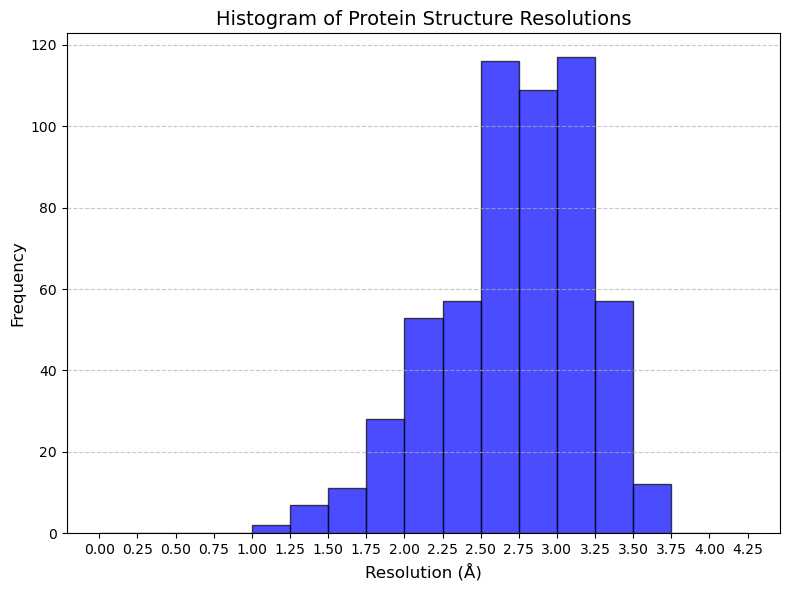

In [16]:
bins = np.arange(0, 4.5, 0.25)

# Create the histogram
plt.figure(figsize=(8, 6))
plt.hist(structures['resolution'], bins=bins, edgecolor='black', alpha=0.7, color='blue')
plt.title('Histogram of Protein Structure Resolutions', fontsize=14)
plt.xlabel('Resolution (Å)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(bins)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

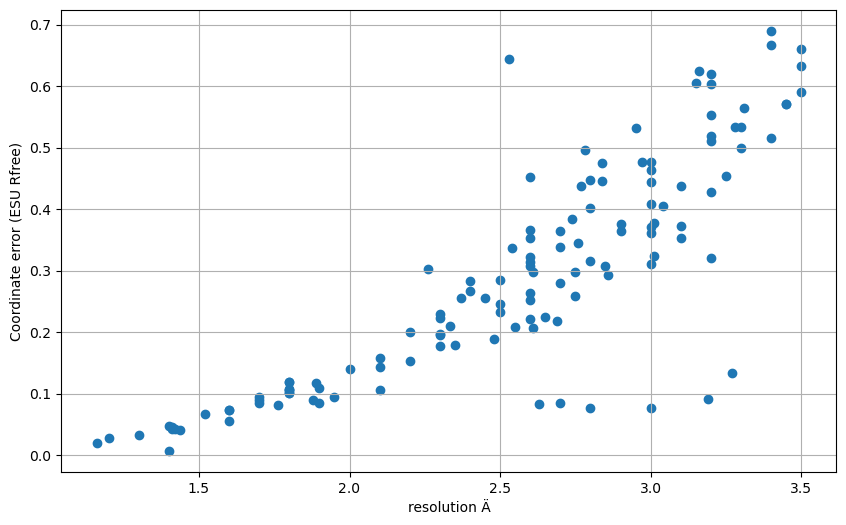

In [19]:
plt.figure(figsize=(10,6))
plt.scatter(structures['resolution'], structures['Coordinate_Error_(ESU_Rfree)'])
plt.xlabel('resolution Ä')
plt.ylabel('Coordinate error (ESU Rfree)')
plt.grid(True)
plt.show()

As resolution increases, coordinate error seems to increase as well. Both are structure qualities indicators.

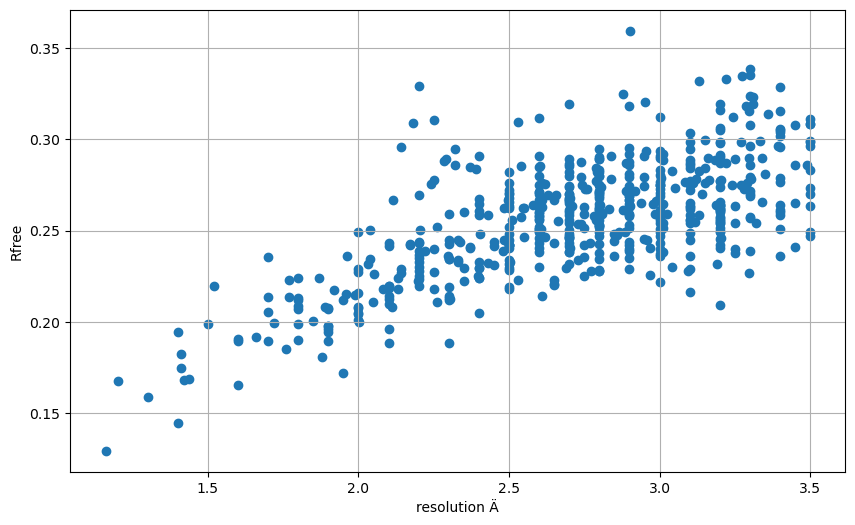

In [18]:
plt.figure(figsize=(10,6))
plt.scatter(structures['resolution'], structures['R-free-factor'])
plt.xlabel('resolution Ä')
plt.ylabel('Rfree')
plt.grid(True)
plt.show()

# To-do

## Discussie van quality in dataset 

### Plots van histograms, kwality metrics correlations. (voor en na filter?)

### Resolutie considerations + impact op dataset
1. Schindler 2020 gebruikte resoluties van 1.65 - 2.35 angstrom, en kon geen correlatie vinden tussen resolutie van structuur en accuracy van results (RMSE)
2. Hahn 2020 raadt cutoffs van 3.5, of 2.0 aan
3. Verschillende structuren die we al hebben hebben resoluties > 2.0 angstrom,

### Quality metrics
1. R, Rfree
2. Coordinate error
3. heel misschien nog iridium match

1, 2 zijn *globale* quality metrics. Voor FEP is vooral belangrijk hoe nauwkeurig het model op de binding site locatie is. Hoe assess ik dit?



In [11]:
structures = pd.read_csv('structures.csv')
structures_filtered = pd.read_csv('structures_filtered.csv')
